In [2]:
import nrrd
import os
import pandas as pd
import numpy as np
from scipy.ndimage import zoom
import csv
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model, save_model
from matplotlib.colors import ListedColormap
import Segment_support_lib

In [3]:
crop_knee_train = 'F:\\Birva_Harsh\\Knee_Crop_Data\\train\\Knee'
crop_mask_train = 'F:\\Birva_Harsh\\Knee_Crop_Data\\train\\Mask'
crop_knee_test = 'F:\\Birva_Harsh\\Knee_Crop_Data\\test\\Knee'
crop_mask_test = 'F:\\Birva_Harsh\\Knee_Crop_Data\\test\\Mask'

In [4]:
knee_train = [os.path.join(crop_knee_train, i) for i in os.listdir(crop_knee_train)]
mask_train = [path.replace('\\Knee\\', '\\Mask\\') for path in knee_train]

knee_test = [os.path.join(crop_knee_test, i) for i in os.listdir(crop_knee_test)]
mask_test = [path.replace('\\Knee\\', '\\Mask\\') for path in knee_test]

In [5]:
df_train = pd.DataFrame( data = {
    'knee': knee_train,
    'mask': mask_train
})

df_test = pd.DataFrame( data = {
    'knee': knee_test,
    'mask': mask_test
})

In [6]:
def load_and_preprocess_image(file_path,resize):
    img,info = nrrd.read(file_path)
    if resize == 128:
        img = img[::2,::2,::2]
    img = np.clip(img, a_min=-1024, a_max=None)
    img = img[:,:,:,np.newaxis]   
    img_scaled = img.astype(np.float32) / 1024.0
    return img_scaled

In [7]:
def load_and_preprocess_mask(file_path,resize):
    img,info = nrrd.read(file_path)
    if resize == 128:
        img = img[::2,::2,::2]
    
    img_1 = np.where(img == 1, 1, 0)
    img_2 = np.where(img == 2, 1, 0)
    img_3 = np.where(img == 3, 1, 0)
    
    mask = np.stack((img_1, img_2, img_3), axis=-1)
    mask = mask.astype(np.float32)
    return mask

In [8]:
def dice_coeff(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coeff_loss(y_true, y_pred, smooth=100):
    return 1 - dice_coeff(y_true, y_pred, smooth)

In [9]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3)
    return dice    

In [11]:
model = tf.keras.models.load_model("F:\\Birva_Harsh\\Knee_models\\unet_256_8.keras", custom_objects={'dice_coeff': dice_coeff ,'dice_coeff_loss': dice_coeff_loss})

In [19]:
'''def knee_split_array(pred_mask):
   
    m1 = pred_mask[:,:,:,:,0]
    m2 = pred_mask[:,:,:,:,1]
    m3 = pred_mask[:,:,:,:,2]
    
    max_values = np.maximum(np.maximum(m1, m2), m3)
    m1[m1 < 0.5] = 0
    m2[m2 < 0.5] = 0
    m3[m3 < 0.5] = 0
    
    mask1 = (m1 == max_values)
    mask2 = (m2 == max_values)
    mask3 = (m3 == max_values)
    
    p1 = (np.where(mask1, m1, 0)>=0.5).astype(np.uint8)
    p2 = (np.where(mask2, m2, 0)>=0.5).astype(np.uint8)
    p3 = (np.where(mask3, m3, 0)>=0.5).astype(np.uint8)
    
    p1 = np.where(p1 == 1,1,0)
    p2 = np.where(p2 == 1,2,0)
    p3 = np.where(p3 == 1,3,0)

    return p1,p2,p3'''
def knee_split_array(pred_mask):
    m1 = pred_mask[..., 0]
    m2 = pred_mask[..., 1]
    m3 = pred_mask[..., 2]
    
    max_values = np.maximum(np.maximum(m1, m2), m3)
    
    # Thresholding and mask creation (adjust threshold as per your needs)
    threshold = 0.5
    m1_thresh = m1 >= threshold
    m2_thresh = m2 >= threshold
    m3_thresh = m3 >= threshold
    
    # Create masks
    mask1 = (m1_thresh & (m1 == max_values)).astype(np.uint8)
    mask2 = (m2_thresh & (m2 == max_values)).astype(np.uint8)
    mask3 = (m3_thresh & (m3 == max_values)).astype(np.uint8)
    
    return mask1,mask2,mask3

In [22]:
def plot_3d(model,img_path,mask_path,resize):
    colors = ['black', 'red', 'lime', 'royalblue']
    
    cmap = ListedColormap(colors)
    norm = plt.cm.colors.Normalize(vmin=0, vmax=3)
    
    img = load_and_preprocess_image(img_path,resize)
    img = img[np.newaxis,:,:,:,:]
    pred_mask = model.predict(img)
    
    mask,minfo = nrrd.read(mask_path)
    if resize == 128:
        mask = mask[::2,::2,::2]
    
    img = np.squeeze(img)
    mask = np.squeeze(mask)
    
    femur, patella, tibia = knee_split_array(pred_mask)

    Segment_support_lib.get_3D_mesh(np.squeeze(femur),None,'femur')
    Segment_support_lib.get_3D_mesh(np.squeeze(patella),None,'patella')
    Segment_support_lib.get_3D_mesh(np.squeeze(tibia),None,'tibia')
    
    #pred_m = femur+patella+tibia
    #pred_m = np.squeeze(pred_m)
    p1 = femur * 1
    p2 = patella * 2
    p3 = tibia * 3
    
    # Combine masks (if needed)
    pred_m = np.squeeze(np.maximum.reduce([p1, p2, p3]))
    
    plt.figure(figsize=(18,12))
    plt.subplot(3, 3, 1)
    plt.imshow(img[resize//2,:,:].T,cmap='gray')
    plt.axis('off')
    plt.title("X")
    
    plt.subplot(3, 3, 2)
    plt.imshow(img[:,resize//2,:].T,cmap='gray')
    plt.axis('off')
    plt.title("Y")
    
    plt.subplot(3, 3, 3)
    plt.imshow(img[:,:,resize//2].T,cmap='gray')
    plt.axis('off')
    plt.title("Z")
    
    
    plt.subplot(3, 3, 4)
    plt.imshow(mask[resize//2,:,:].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Mask X")
    
    plt.subplot(3, 3, 5)
    plt.imshow(mask[:,resize//2,:].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Mask Y")
    
    plt.subplot(3, 3, 6)
    plt.imshow(mask[:,:,resize//2].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Mask Z")
    
    plt.subplot(3, 3, 7)
    plt.imshow(pred_m[resize//2,:,:].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Pred Mask X")
    
    plt.subplot(3, 3, 8)
    plt.imshow(pred_m[:,resize//2,:].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Pred Mask Y")
    
    plt.subplot(3, 3, 9)
    plt.imshow(pred_m[:,:,resize//2].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Pred Mask Z")
plt.show()

1/1 [==============================] - 0s 53ms/step


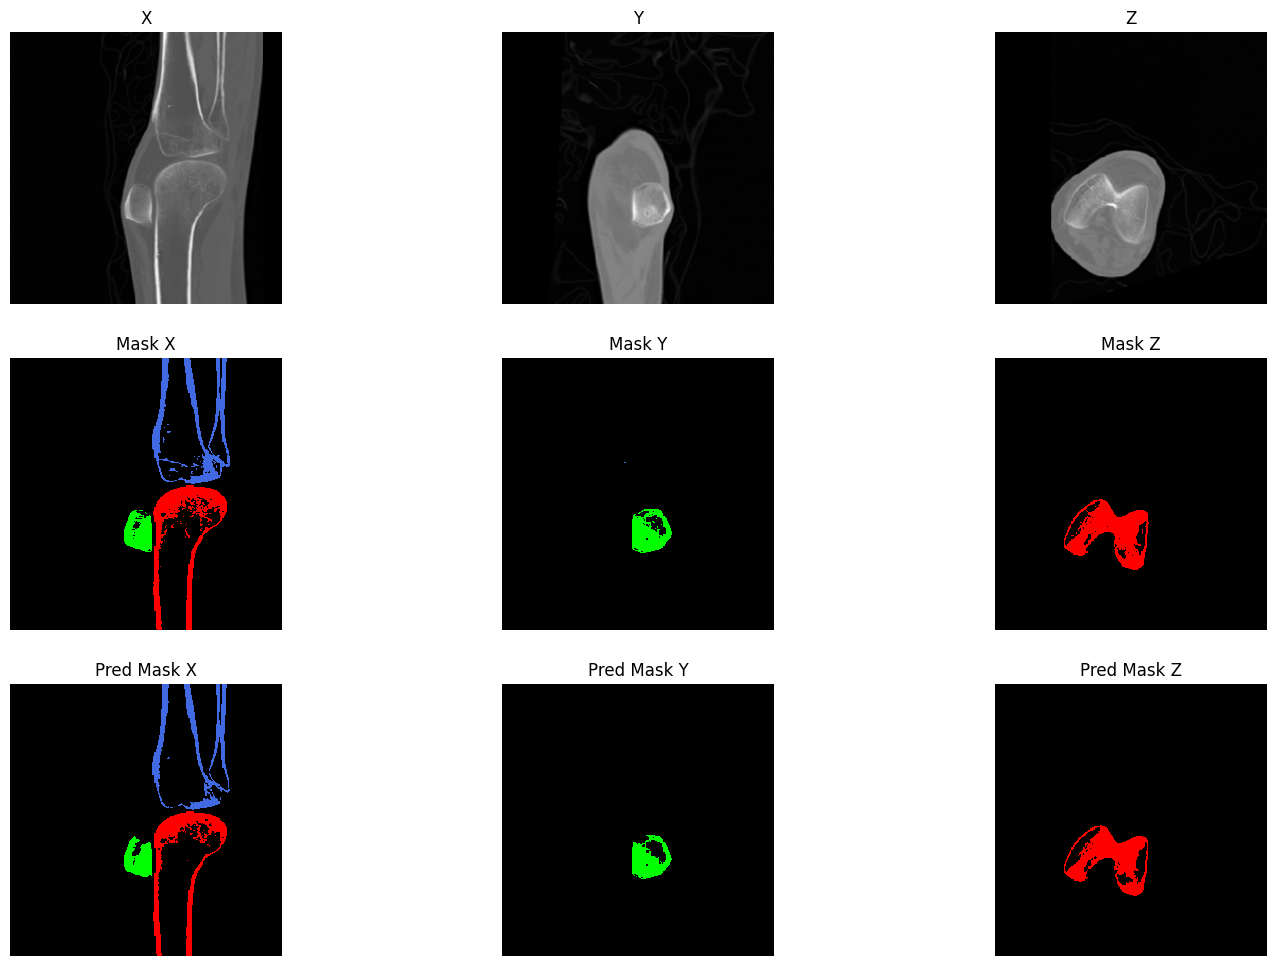

In [24]:
plot_3d(model,df_train.loc[4,'knee'],df_train.loc[4,'mask'],256)

In [29]:
def mesh_3d(model,img_path,mask_path,index,resize):
    colors = ['black', 'red', 'lime', 'royalblue']
    
    cmap = ListedColormap(colors)
    norm = plt.cm.colors.Normalize(vmin=0, vmax=3)
    
    img = load_and_preprocess_image(img_path,resize)
    img = img[np.newaxis,:,:,:,:]
    pred_mask = model.predict(img)
    
    mask,minfo = nrrd.read(mask_path)
    if resize == 128:
        mask = mask[::2,::2,::2]
    
    img = np.squeeze(img)
    mask = np.squeeze(mask)
    
    femur, patella, tibia = knee_split_array(pred_mask)
    patient_name = os.path.basename(img_path).split('.')[0]
    
    base_path = f'F:\\Birva_Harsh\\3D segmentation\\Knee\\Unet\\{patient_name}'
    os.makedirs(base_path, exist_ok=True)
    
    femur_path = f'F:\\Birva_Harsh\\3D segmentation\\Knee\\Unet\\{patient_name}\\femur'
    patella_path = f'F:\\Birva_Harsh\\3D segmentation\\Knee\\Unet\\{patient_name}\\patella'
    tibia_path = f'F:\\Birva_Harsh\\3D segmentation\\Knee\\Unet\\{patient_name}\\tibia'
    
    Segment_support_lib.get_3D_mesh(np.squeeze(femur),None,femur_path)
    Segment_support_lib.get_3D_mesh(np.squeeze(patella),None,patella_path)
    Segment_support_lib.get_3D_mesh(np.squeeze(tibia),None,tibia_path)
    
    stl_files = [
        femur_path+'.stl',
        patella_path+'.stl',
        tibia_path+'.stl'    
    ]
    colors = [
    [1.0, 0.0, 0.0],  
    [0.0, 1.0, 0.0],  
    [0.0, 0.0, 1.0]   
]
    combined_file = f'F:\\Birva_Harsh\\3D segmentation\\Knee\\Unet\\{patient_name}\\combined.stl'
    Segment_support_lib.combine_stl_files(stl_files,combined_file,colors)

In [30]:
for i in df_test.index:
    mesh_3d(model,df_test.loc[i,'knee'],df_test.loc[i,'mask'],i,256)

1/1 [==============================] - 0s 36ms/step


In [ ]:
index = np.random.randint(0, len(df_test.index))
mesh_3d(model,df_test.loc[10,'knee'],df_test.loc[10,'mask'],256)

# New NRRD Test Data

In [10]:
data_path = 'F:\\Birva_Harsh\\New_nrrd_crop'

In [11]:
test_files = glob(pathname = data_path+'\\*')
test_files

['F:\\Birva_Harsh\\New_nrrd_crop\\3LT.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\5350lt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\5353rt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\5362rt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\5363lt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\5372rt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\5373rt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\5378rt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\5381lt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\5385lt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\5394lt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\CT_1_lt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\CT_4_lt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\CT_4_rt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\CT_5307_lt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\CT_5340_rt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\CT_5345_rt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\CT_5348_rt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\CT_5352_lt.nrrd',
 'F:\\Birva_Harsh\\New_nrrd_crop\\CT_5367_lt.nrrd',
 'F:\\Birva_Hars

In [13]:
def mesh_3d(model,img_path,out_path,resize):
    colors = ['black', 'red', 'lime', 'royalblue']
    
    cmap = ListedColormap(colors)
    norm = plt.cm.colors.Normalize(vmin=0, vmax=3)
    
    img = load_and_preprocess_image(img_path,resize)
    img = img[np.newaxis,:,:,:,:]
    pred_mask = model.predict(img)
    
    img = np.squeeze(img)
    
    femur, patella, tibia = knee_split_array(pred_mask)
    patient_id = os.path.basename(img_path).split('.')[0]
    
    base_path = os.path.join(out_path ,patient_id)
    os.makedirs(base_path, exist_ok=True)
    
    femur_path = os.path.join(base_path,'femur')
    patella_path = os.path.join(base_path,'patella')
    tibia_path = os.path.join(base_path,'tibia')
    
    Segment_support_lib.get_3D_mesh(np.squeeze(femur),None,femur_path)
    Segment_support_lib.get_3D_mesh(np.squeeze(patella),None,patella_path)
    Segment_support_lib.get_3D_mesh(np.squeeze(tibia),None,tibia_path)
    
    stl_files = [
        femur_path+'.stl',
        patella_path+'.stl',
        tibia_path+'.stl'    
    ]
    colors = [
    [1.0, 0.0, 0.0],  
    [0.0, 1.0, 0.0],  
    [0.0, 0.0, 1.0]   
]
    combined_file = os.path.join(base_path,'combined.stl')
    Segment_support_lib.combine_stl_files(stl_files,combined_file,colors)

In [14]:
out_path = f'F:\\Birva_Harsh\\New_nrrd_crop_segment'

In [15]:
mesh_3d(model,'F:\\Birva_Harsh\\New_nrrd_crop\\5353rt.nrrd',out_path,256)

1/1 [==============================] - 0s 52ms/step


In [22]:
for i in test_files:
    mesh_3d(model,i,out_path,256)

1/1 [==============================] - 0s 27ms/step


In [16]:
len(test_files)

21

In [11]:
out_path = f'F:\\Birva_Harsh\\test'

In [14]:
mesh_3d(model,'F:\Birva_Harsh\Knee_Crop_Data\Knee\93_2.nrrd',out_path,256)

1/1 [==============================] - 0s 45ms/step
